In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import io
import chess
import chess.pgn
import chess.svg
import numpy as np
import os
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix, vstack
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from joblib import dump, load
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from ipywidgets import widgets, HBox
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import base64

In [2]:
def games_from_drive():
    max_games = 500000 
    asset_dir = 'asset'
    file_name = '2023_tc_500000_games.pgn'

    gauth = GoogleAuth()
    gauth.DEFAULT_SETTINGS['client_config_file'] = 'client_secret_1057507276332-5mk9ac9q22rsmtm1idlqvpraq08ar8p5.apps.googleusercontent.com.json'
    gauth.LoadCredentialsFile("mycreds.txt")
    if gauth.credentials is None:
        gauth.LocalWebserverAuth()
    elif gauth.access_token_expired:
        gauth.Refresh()
    else:
        gauth.Authorize()

    gauth.SaveCredentialsFile("mycreds.txt")
    drive = GoogleDrive(gauth)

    def load_pgns_from_text(pgns_text, num_games=None, start_index=0, encoding="utf-8"):
        games = []
        file_io = io.StringIO(pgns_text)
        for _ in tqdm(range(start_index), desc='Skipping games', unit='game', leave=False):
            game = chess.pgn.read_game(file_io)
            if game is None:
                break
        for _ in tqdm(range(num_games), desc='Loading games', unit='game', leave=True) if num_games else iter(int, 1):
            game = chess.pgn.read_game(file_io)
            if game is None:
                break
            games.append(game)
        return games

    def find_folder_id(folder_name):
        file_list = drive.ListFile({'q': f"title='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
        for file in file_list:
            if file['title'] == folder_name:
                return file['id']
        return None

    def read_pgn_file_from_drive(file_title, parent_id):
        query = f"'{parent_id}' in parents and trashed=false and title='{file_title}'"
        file_list = drive.ListFile({'q': query}).GetList()
        if not file_list:
            print(f"No file found with title: {file_title}")
            return None
        file = file_list[0]
        urls = file.GetContentString(encoding='UTF-8')
        return urls

    chess_games_loaded = False
    print("loading pgn...")
    asset_folder_id = find_folder_id(asset_dir)

    if asset_folder_id is None:
        print("Asset folder not found.")
    else:
        pgns_text = read_pgn_file_from_drive(file_name, asset_folder_id)
        games = load_pgns_from_text(pgns_text, num_games=max_games)
        if games is not None:
            print("pgn file loaded successfully.")
    return games

In [3]:
def load_pgns(file_path, num_games=None, start_index=0, encoding="utf-8"):
    games = []
    with open(file_path, "r", encoding=encoding) as file:
        for _ in tqdm(range(start_index), desc='Skipping games', unit='game', leave=False):
            game = chess.pgn.read_game(file)
            if game is None:
                break
        for _ in tqdm(range(num_games), desc='Loading games', unit='game', leave=True) if num_games else iter(int, 1):
            game = chess.pgn.read_game(file)
            if game is None:
                break
            games.append(game)
    return games

In [4]:
assets_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
single_path = os.path.join(assets_path, 'kgames_sample.pgn')
games = load_pgns(single_path, 1000)
#games = games_from_drive()

Loading games: 100%|██████████| 1000/1000 [00:02<00:00, 364.96game/s]


In [5]:
def game_to_csr_matrix(game):
    board = game.board()
    fen_array_list = []
    for move in game.mainline_moves():
        board.push(move)
        fen_array = board_to_array(board)
        fen_array_list.append(fen_array)
    game_csr_matrix = csr_matrix(np.array(fen_array_list))
    return game_csr_matrix

def board_to_array(board):
    standard_counts = [8,2,2,2,1]
    board_array = []
    materials = []
    for color in chess.COLORS:
        for piece in chess.PIECE_TYPES:
            vector, count = bitboard_of_piece(board, piece, color)
            board_array.extend(vector)
            try:
                materials.append(count/standard_counts[piece-1])
            except:
                pass

    castles = get_castle_info(board)
    peasants = get_en_passant_array(board)
    board_array.extend(castles)
    board_array.extend(peasants)
    board_array.extend(materials)

    turn = board.turn
    halfmove_clock = board.halfmove_clock * 0.01
    board_array.append(turn)  # 1 for white's turn, 0 for black's turn
    board_array.append(halfmove_clock)
    
    return np.array(board_array)

def bitboard_of_piece(board, piece_type, color):
    bit_array = np.zeros(64, dtype=int)
    squares = list(board.pieces(piece_type, color))
    piece_count = len(squares)
    bit_array[squares] = 1
    return bit_array, piece_count

def get_en_passant_array(board):
    en_passant_array = np.zeros(64, dtype=int)
    if board.ep_square is not None:
        en_passant_array[board.ep_square] = 1
    relevant_squares = np.concatenate((en_passant_array[16:24], en_passant_array[40:48]))
    return relevant_squares

def get_castle_info(board):
    white_kingside = board.has_castling_rights(chess.WHITE) and board.has_kingside_castling_rights(chess.WHITE)
    white_queenside = board.has_castling_rights(chess.WHITE) and board.has_queenside_castling_rights(chess.WHITE)
    black_kingside = board.has_castling_rights(chess.BLACK) and board.has_kingside_castling_rights(chess.BLACK)
    black_queenside = board.has_castling_rights(chess.BLACK) and board.has_queenside_castling_rights(chess.BLACK)
    return [white_kingside, white_queenside, black_kingside, black_queenside]

In [6]:
def index_to_piece_square(input_num, san=False):
    if input_num > 767:
        toret = index_to_plus_feature(input_num)
        return toret
    piece_colors = ["White", "Black"]
    type_list = ["Pawn", "Knight", "Bishop", "Rook", "Queen", "King"]
    type_l = ["P", "N", "B", "R", "Q", "K"]
    square_files = "abcdefgh"
    square_ranks = "12345678"

    piece_int = input_num // 64
    piece_col = int(piece_int > 5)
    PieceColor = piece_colors[piece_col]
    type_int = piece_int % 6
    PieceName = type_list[type_int]
    square_int = input_num % 64
    square_file = square_files[square_int % 8]
    square_rank = square_ranks[square_int // 8]

    if san:
        piece_symbols = [p.lower() if piece_col else p for p in type_l]
        piece = piece_symbols[type_int]
        return f'{piece}{square_file}{square_rank}'

    return f'{PieceColor} {PieceName} on {square_file}{square_rank}'

def index_to_plus_feature(input_num):
    if input_num < 768:
        print('This function is intended for input numbers greater than 767.')
        return None
    
    elif 768 <= input_num <= 771:
        castling_rights = ["White_Kingside", "White_Queenside", "Black_Kingside", "Black_Queenside"]
        return f'Castle_{castling_rights[input_num - 768]}'
    
    elif 772 <= input_num < 788:
        square_files = "abcdefgh"
        square_ranks = "36"  # En passant can only target these ranks
        en_passant_file = square_files[(input_num - 772) % 8]
        en_passant_rank = square_ranks[(input_num - 772) // 8]
        return f'en_passant {en_passant_file}{en_passant_rank}'
    
    elif input_num == 798:
        return 'turn_w'
    
    elif input_num == 799:
        return 'Halfmove_Clock'
    
    else:
        color = (input_num - 788) // 5
        type = (input_num - 788) % 5
        piece_colors = ["White", "Black"]
        type_list = ["Pawn", "Knight", "Bishop", "Rook", "Queen", "King"]
        return f'Material_{piece_colors[color]}_{type_list[type]}'

In [7]:
def vector_to_fen(vector):
    piece_symbols = "PNBRQKpnbrqk"
    board = [""] * 64

    for square in range(64):
        for piece_index in range(12):
            if vector[piece_index * 64 + square] == 1:
                board[square] = piece_symbols[piece_index]
                break

    fen_parts = []
    for rank in range(8, 0, -1):
        empty_count = 0
        rank_str = ""
        for file in range(8):
            piece = board[(rank-1)*8 + file]
            if piece == "":
                empty_count += 1
            else:
                if empty_count > 0:
                    rank_str += str(empty_count)
                    empty_count = 0
                rank_str += piece
        if empty_count > 0:
            rank_str += str(empty_count)
        fen_parts.append(rank_str)

    piece_placement = "/".join(fen_parts)
    
    active_color = "w" if vector[-2] == 1 else "b"
    
    castling_rights = ''.join(['K' if vector[768] == 1 else '',
                               'Q' if vector[769] == 1 else '',
                               'k' if vector[770] == 1 else '',
                               'q' if vector[771] == 1 else '',])
    if castling_rights == "":
        castling_rights = "-"

    en_passant_vector = vector[772:788]
    en_passant_target = "-"
    for i, val in enumerate(en_passant_vector):
        if val == 1:
            en_passant_target = chess.SQUARE_NAMES[16 + i] if i < 8 else chess.SQUARE_NAMES[40 + (i - 8)]
            break
    
    halfmove_clock = int(vector[-1])
    
    fullmove_number = "1"
    
    fen = f"{piece_placement} {active_color} {castling_rights} {en_passant_target} {halfmove_clock} {fullmove_number}"
    
    return fen

In [8]:
try:
    all_board_csr_matrix = load('fen_csr_matrix.joblib')
except:
    game_csr_matrices = [game_to_csr_matrix(game) for game in games]
    all_board_csr_matrix = vstack(game_csr_matrices)
    dump(all_board_csr_matrix, 'fen_csr_matrix.joblib')

In [9]:
def apply_norm_and_idf(matrix):
    idf = get_idf_from_doc_term_mat(matrix)
    fen_idf_matrix = matrix.multiply(idf)
    fen_idf_matrix_norm = normalize(fen_idf_matrix, norm='l2', axis=1)
    return fen_idf_matrix_norm

def get_idf_from_doc_term_mat(matrix):
    document_frequencies = matrix.getnnz(axis=0)
    N = matrix.shape[0]
    normalizer = np.log(1 + N) + 1
    idf = (np.log((1 + N) / (1 + document_frequencies)) + 1)/normalizer
    return idf

def apply_query_transformations(query, matrix=all_board_csr_matrix):
    idf = get_idf_from_doc_term_mat(matrix)
    scaled_query = query.reshape(1, -1) * idf
    normalized_query = normalize(scaled_query, norm='l2', axis=1)
    return normalized_query

In [10]:
fen_idf_matrix_norm = apply_norm_and_idf(all_board_csr_matrix)

In [11]:
n_components = 100
svd = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
fens_reduced = svd.fit_transform(fen_idf_matrix_norm)

In [12]:
def fen_to_img_html(fen, size=500):
    board = chess.Board(fen)
    svg = chess.svg.board(board, size=size)
    svg_bytes = svg.encode('utf-8')
    b64_svg = base64.b64encode(svg_bytes).decode('utf-8')
    return f'<img src="data:image/svg+xml;base64,{b64_svg}" style="max-width:100%; height: auto;"/>'

def get_fen_string(index):
    return vector_to_fen(all_board_csr_matrix[index].toarray()[0])

def index_to_endgame_status(ind):
    piece_materials = all_board_csr_matrix[ind].toarray()[0][-11:-2]
    piece_materials[4] = 0
    if sum(piece_materials) < 4:
        return 'endgame'
    else:
        return '' 

lightest_color = '#eeeed2'
darkest_color = '#ccaa87'
walnut = [[0, lightest_color],[1, darkest_color]]

pca_3d = PCA(n_components=3)
reduced_data_pca_3d = pca_3d.fit_transform(fens_reduced)

#hover_text_3d = [f'FEN: {get_fen_string(i)}' for i in range(len(reduced_data_pca_3d))]
hover_text_3d = [f'{index_to_endgame_status(i)}' for i in range(len(reduced_data_pca_3d))]

fig = go.Figure(data=[go.Scatter3d(
    x=reduced_data_pca_3d[:, 0],
    y=reduced_data_pca_3d[:, 1],
    z=reduced_data_pca_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.1,
        color=list(range(len(reduced_data_pca_3d))),
        colorscale=walnut,
    ),
    hoverinfo='text',
    text=hover_text_3d
)])

fig.update_layout(
    width=500,
    height=500,
    scene=dict(
        xaxis_title='PC X',
        yaxis_title='PC Y',
        zaxis_title='PC Z'
    ),
    margin=dict(r=0, b=0, l=0, t=0)
)

fig_widget = go.FigureWidget(fig)
chessboard_display = widgets.HTML()

def update_chessboard(trace, points, _):
    if points.point_inds:
        index = points.point_inds[0]
        fen = get_fen_string(index)
        chessboard_display.value = fen_to_img_html(fen)

for trace in fig_widget.data:
    trace.on_hover(update_chessboard)

from ipywidgets import Layout
widgets_layout = HBox([fig_widget, chessboard_display], layout=Layout(justify_content='space-between', padding='100px'))
display(widgets_layout)

    'data': [{'hoverinfo': 'text',
              'marker': {'color': [0, 1, 2, .…

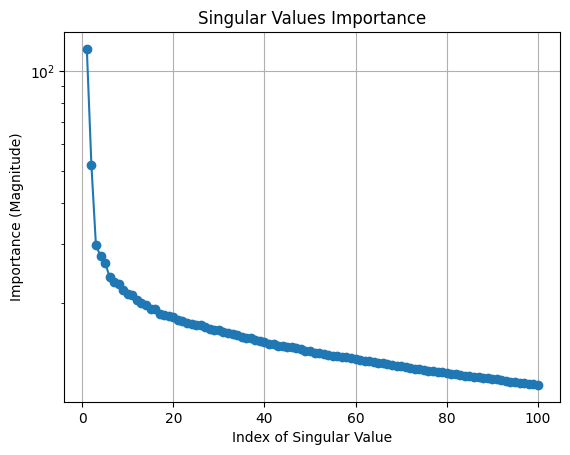

In [13]:
plt.plot(range(1,n_components+1), svd.singular_values_, marker='o')
plt.title('Singular Values Importance')
plt.xlabel('Index of Singular Value')
plt.ylabel('Importance (Magnitude)')
plt.yscale('log')
plt.grid(True)
plt.show()

In [14]:
num_top_components = 10
num_top_features = 30
for i, component in enumerate(svd.components_[:num_top_components]):
    feature_indices = np.argsort(np.abs(component))[::-1][:num_top_features]
    print(f"Top {num_top_features} features for component {i+1}:")
    for feature_index in feature_indices:
        importance = np.abs(component[feature_index])
        feature_name = index_to_piece_square(feature_index)
        print(f"{feature_name}: Importance {importance}")
    print()

Top 30 features for component 1:
Black Rook on a8: Importance 0.15776524514361515
White Rook on a1: Importance 0.15766331765319788
Black King on e8: Importance 0.15287664438615026
Castle_Black_Queenside: Importance 0.15277783838259257
Castle_Black_Kingside: Importance 0.15274559758029377
Black Rook on h8: Importance 0.15205050892247382
Black Queen on d8: Importance 0.15034704860272452
Castle_White_Kingside: Importance 0.15015155203904912
Castle_White_Queenside: Importance 0.1499073689524636
White King on e1: Importance 0.14987477902457075
White Pawn on b2: Importance 0.14953972670915103
White Rook on h1: Importance 0.14923438029298666
White Queen on d1: Importance 0.14894220101867214
Black Pawn on b7: Importance 0.1477403330587103
White Pawn on a2: Importance 0.14770096616728692
White Pawn on h2: Importance 0.1475473648755506
White Pawn on g2: Importance 0.14663323618529875
Black Pawn on h7: Importance 0.14639496497971136
Black Pawn on a7: Importance 0.1462360365275556
Black Pawn on f7

In [15]:
#query_fen = 'rnb2b1r/2Nnkppp/p2pp3/8/PPBN1P2/2p3Pq/4Q2P/R3K1R1 w Q - 1 17' #wild opening
query_fen = '6k1/5p2/1r2p1p1/3p1n2/3P3p/1P1R3P/4NPP1/6K1 b - - 2 36' #knight rook endgame
query_array = board_to_array(chess.Board(fen=query_fen))
transformed_query_array = apply_query_transformations(query_array)
query_array_reduced = svd.transform(transformed_query_array.reshape(1, -1))

In [16]:
k=25

norm_X_reduced = fens_reduced / np.linalg.norm(fens_reduced, axis=1, keepdims=True)
norm_query_vector_reduced = query_array_reduced / np.linalg.norm(query_array_reduced)

cos_similarities = 1 - cdist(norm_X_reduced, norm_query_vector_reduced, metric='cosine')
cos_similarities = cos_similarities.flatten()

top_k_indices = np.argsort(cos_similarities)[-k:][::-1]

cos_similarities[top_k_indices]

array([0.70400362, 0.69552166, 0.68622609, 0.66156724, 0.66155379,
       0.66014382, 0.65167625, 0.63846313, 0.63680162, 0.63476245,
       0.63179905, 0.63126804, 0.62982338, 0.62947137, 0.62818855,
       0.62171481, 0.62017916, 0.6174133 , 0.61522472, 0.59630337,
       0.58961364, 0.58621522, 0.58103432, 0.57891084, 0.57634742])

6k1/5p2/1r2p1p1/3p1n2/3P3p/1P1R3P/4NPP1/6K1 b - - 0 1


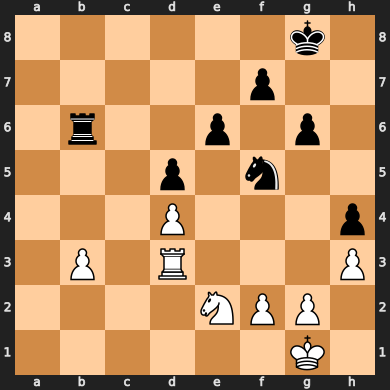

----------------------------------------------------------------
R5k1/5p2/4p1p1/3p2rn/3P3p/5P2/4NK2/8 b - - 0 1


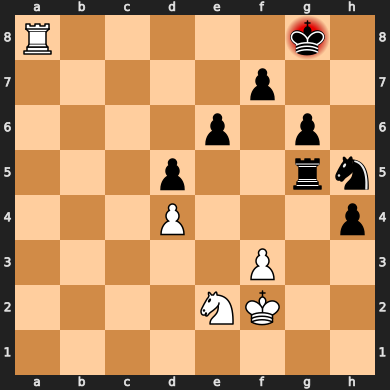

6k1/5p2/4p1p1/3p3n/R2P3p/5Pr1/4NK2/8 b - - 0 1


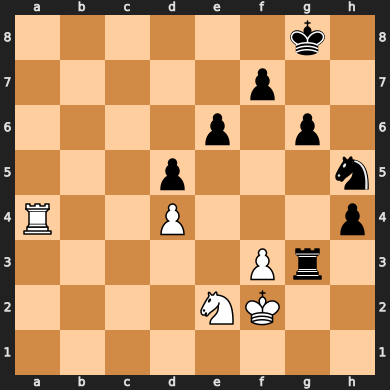

6k1/5p2/4p1p1/3p2rn/R2P3p/5P2/4NK2/8 w - - 0 1


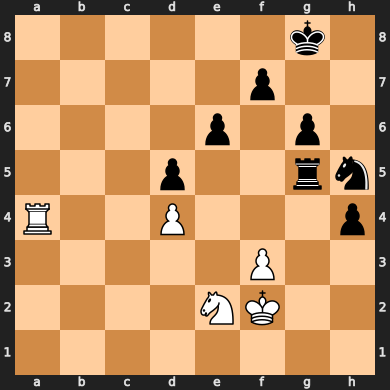

6k1/p4p1p/4p1p1/2B5/2P1q3/1P5P/r5P1/5QK1 w - - 0 1


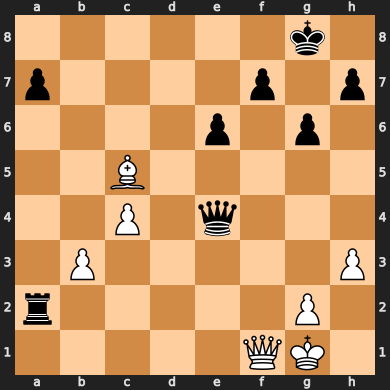

6k1/p4p1p/4p1p1/2B5/2P1q3/1P5P/P2r2P1/5QK1 b - - 0 1


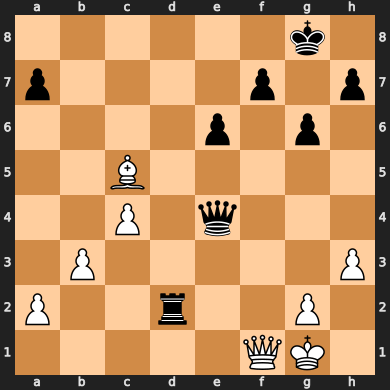

6k1/p3Bp1p/4p1p1/8/2P1q3/1P5P/r5P1/5QK1 b - - 0 1


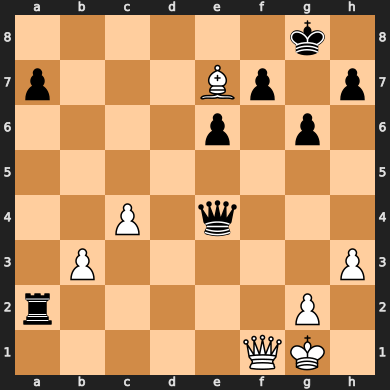

6k1/p3Bp1p/4p1p1/8/2P2q2/1P5P/5rP1/3Q2K1 b - - 0 1


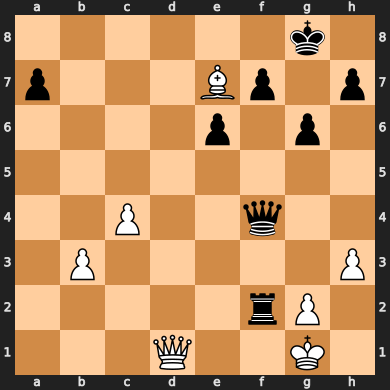

6k1/p3Bp1p/4p1p1/8/2P5/1P3q1P/3r2P1/6K1 w - - 0 1


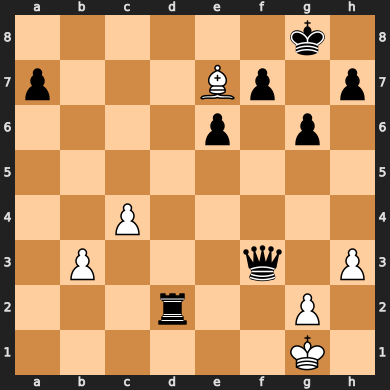

6k1/p3Bp1p/4p1p1/8/2P5/1P2q2P/r5P1/5QK1 w - - 0 1


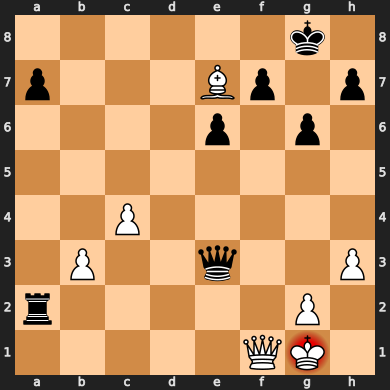

8/8/3k4/1n6/3P3p/4KB1P/8/8 b - - 0 1


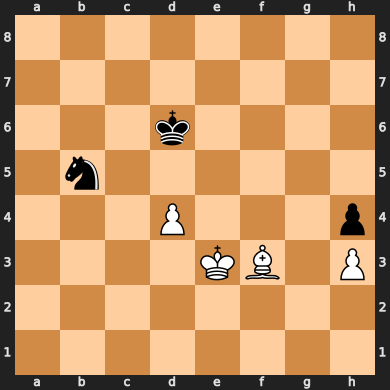

8/5pk1/4p1p1/3p2rn/3P3p/5P2/4NK2/R7 b - - 0 1


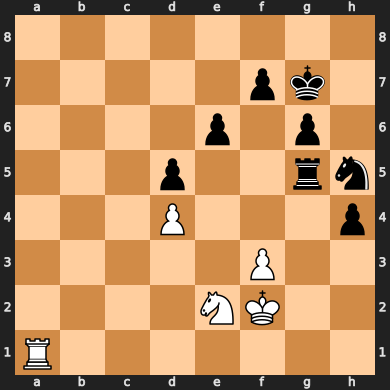

r1r3k1/6pp/p5n1/5n2/Q7/1PP4P/4NPP1/R5K1 w - - 0 1


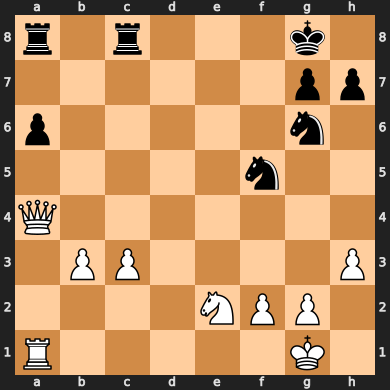

8/5pk1/4p1p1/3p2r1/3P3p/5Pn1/4NK2/R7 w - - 0 1


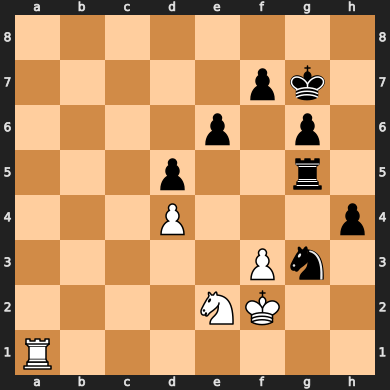

R7/5pk1/4p1p1/3p2rn/3P3p/5P2/4NK2/8 w - - 0 1


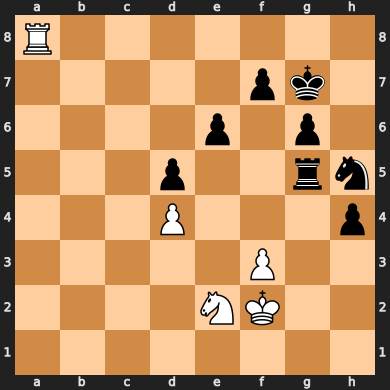

6k1/p3Bp1p/4p1p1/8/2P2q2/1P5P/3r2P1/3Q2K1 w - - 0 1


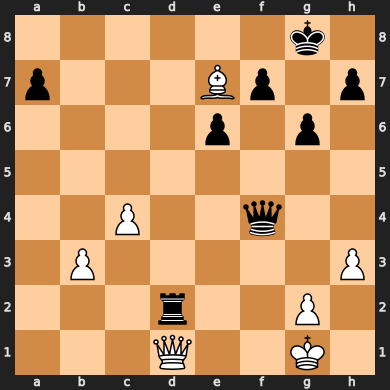

6k1/ppp2p1p/6p1/1q1p4/8/1PP4P/2Q2PP1/6K1 w - - 0 1


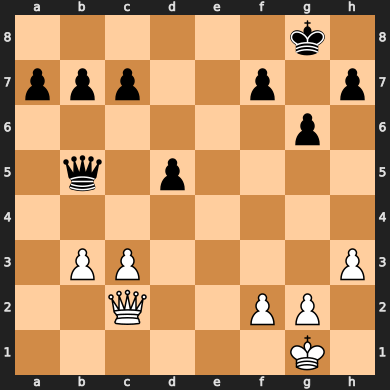

6k1/1pp2p2/1p1b2p1/8/r4P2/1P5P/3RN3/6K1 b - - 0 1


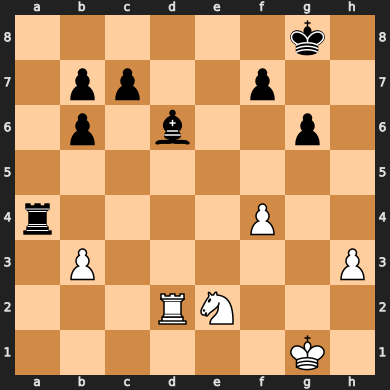

6k1/ppp2p1p/6p1/1q1p4/2P5/1P5P/2Q2PP1/6K1 b - - 0 1


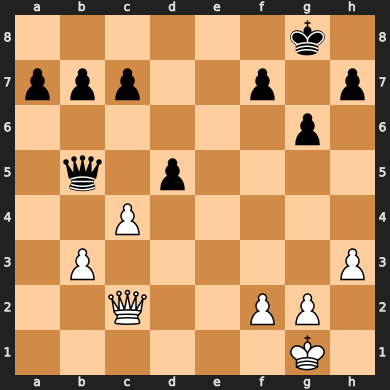

6k1/1pp2p2/1p1b2p1/8/1r3P2/1P5P/3RN3/6K1 w - - 0 1


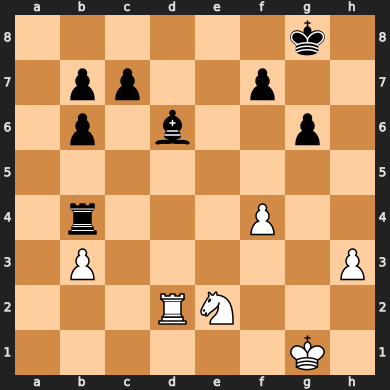

6k1/1pp2p2/1p4p1/4b3/r4P2/7P/1P1RN3/6K1 b - - 0 1


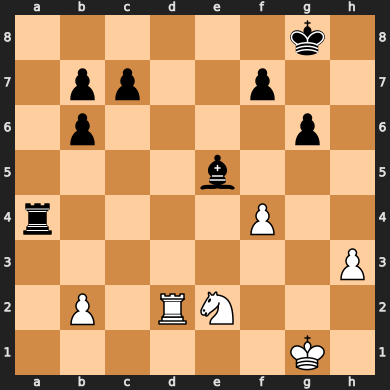

6k1/1pp2p2/1p1b2p1/8/1r3P2/1P5P/3RNK2/8 b - - 0 1


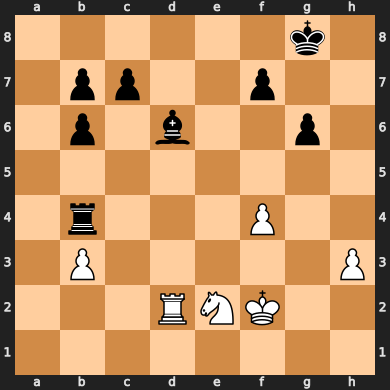

6k1/p3Bp1p/4p1p1/8/2P5/1P2q2P/r5PK/5Q2 b - - 0 1


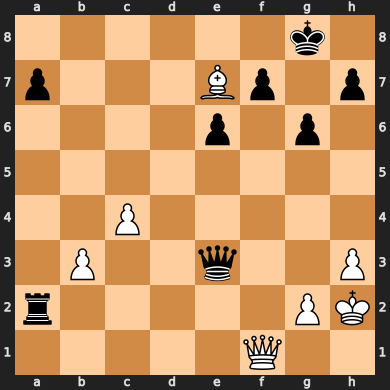

6k1/1pp2p2/1p4p1/4b3/r7/5P1P/1P1RN3/6K1 w - - 0 1


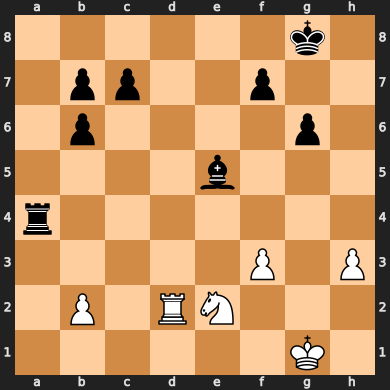

r5k1/1pp2p2/1p4p1/4b3/B7/5P1P/1P1RN3/6K1 b - - 0 1


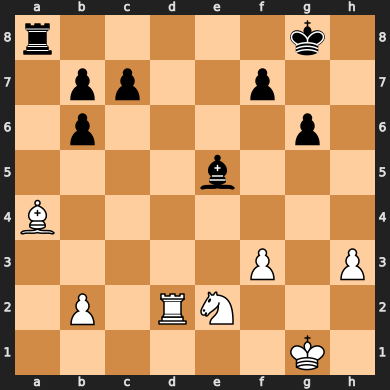

6k1/p3Bp1p/4p1p1/8/2P5/1P2q2P/5rPK/5Q2 w - - 0 1


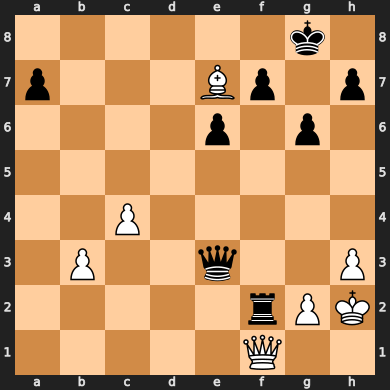

In [17]:
print(vector_to_fen(query_array))
display(chess.Board(fen=query_fen))
print('-'*64)

for ind in top_k_indices:
    fen_array = all_board_csr_matrix[ind]
    fen_string = vector_to_fen(fen_array.toarray()[0])
    print(fen_string)
    display(chess.Board(fen=fen_string))